本脚本研究从旋转框内取子图的过程，并且实现以下两种方式取值
- 大图先旋转，将旋转框摆正后，再取子区域
- 先从大图取出子区域的外接矩形，摆正这个子区域再取子区域


总结：旋转后，包括中心点在内的像素值发生改变，不可能取回原图像素值

In [1]:
#查看图片
import cv2
import math 
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

def show_images(images,lines=[],closize=2,set_locator=False,titles=[]):
    # 计算行数量
    rows=int(len(images)/closize)+1
    
    fig=plt.figure(figsize=(20,20))
    for find,image in enumerate(images):
        ax=fig.add_subplot(rows,closize,find+1) #每个子图
        ax.imshow(image)
        
        # 标题
        if len(titles)==0:
            plt.title('{}-({})'.format(find,image.shape)) #图片大小作为标题
        else:
            plt.title('{}-({})'.format(titles[find],image.shape)) #自定义标题
        
        # 标度
        h,w=image.shape[:2]
        plt.yticks(range(h),[str(i) for i in range(0,h)])
        plt.xticks(range(w),[str(i) for i in range(0,w)])

        # 显示网格线
        ax.grid(which='both')
        
        # 加像素值
        for row_ind in range(len(image)):
            for clo_ind in range(len(image[row_ind])):
                plt.text(row_ind,clo_ind,image[row_ind][clo_ind])
            
        # 绘制直线
        if len(lines)>0:
            for idx in range(len(lines)):
                p1=lines[idx%len(lines)]
                p2=lines[(idx+1)%len(lines)]
                plt.plot([p1[0],p2[0]],[p1[1],p2[1]])

    plt.show()

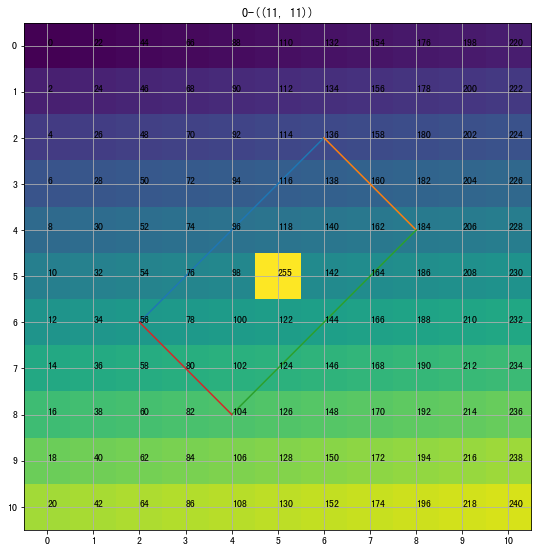

In [2]:
# 模拟待处理图片，每个交点是一个像素，里面的值模拟为像素值
import numpy as np
img = np.zeros((11, 11),np.uint8)
i=0
for row in range(11):
    for col in range(11):
        img[row,col] = i*2
        i+=1

# 模拟旋转框
center = (5, 5)  # 中心点坐标
size = (3, 5)  # 宽度和高度
angle = 45  # 旋转角度

# 设置中心点为255
img[center]=255

# 计算旋转框的四个顶点
rect = cv2.boxPoints(((center[0], center[1]), size, angle))
# rect = np.int0(rect)
rect = np.round(rect)

show_images([img],lines=rect)

In [3]:
# 求一个点绕另一个点旋转后的位置
def rotate_point(cx, cy, x, y, angle_deg):  
    # 将角度从度转换为弧度  
    angle_rad = math.radians(angle_deg)  
      
    # 创建旋转矩阵  
    # 注意：OpenCV的旋转矩阵是逆时针的，这里我们也是逆时针  
    rotation_matrix = np.array([[math.cos(angle_rad), -math.sin(angle_rad)],  
                                [math.sin(angle_rad), math.cos(angle_rad)]])  
      
    # 平移点(x, y)到原点  
    point_shifted = np.array([x - cx, y - cy])  
      
    # 应用旋转矩阵  
    rotated_point_shifted = np.dot(rotation_matrix, point_shifted)  
      
    # 将旋转后的点平移回(cx, cy)  
    rotated_x = rotated_point_shifted[0] + cx  
    rotated_y = rotated_point_shifted[1] + cy  
      
    return int(rotated_x), int(rotated_y)  


## 1.大图摆正后再取值

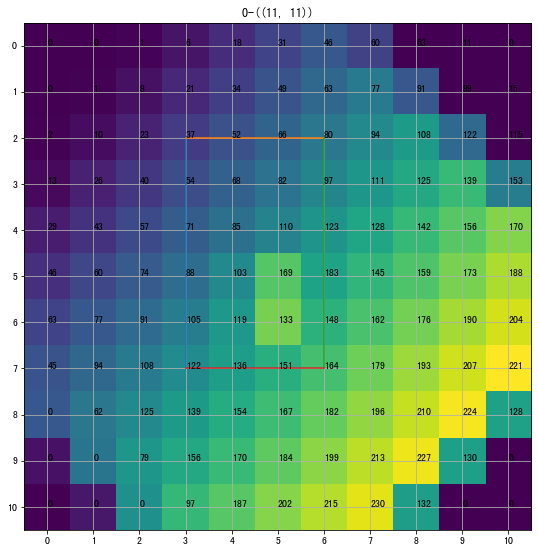

[[ 37  54  71  88 105]
 [ 52  68  85 103 119]
 [ 66  82 110 169 133]]


In [4]:
# 将大图旋转为0度
w,h=11,11
M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1) # 逆时针角度为正，顺时针角度为负
rotated_image = cv2.warpAffine(img, M, (w, h))

cx, cy = center[0], center[1]  # 旋转中心      
angle_deg = 45     # 旋转角度（度） 
# 所有要旋转的点  
now_rect = [rotate_point(cx, cy, rx, ry, -angle_deg) for rx,ry in rect ]

show_images([rotated_image],lines=now_rect)

# 取旋转框内的值
X=[rx for rx,ry in now_rect]
Y=[ry for rx,ry in now_rect]
sub_img1=rotated_image[min(X):max(X),min(Y):max(Y)]
print(sub_img1)

## 2.取出子区域，旋转摆正后取目标框

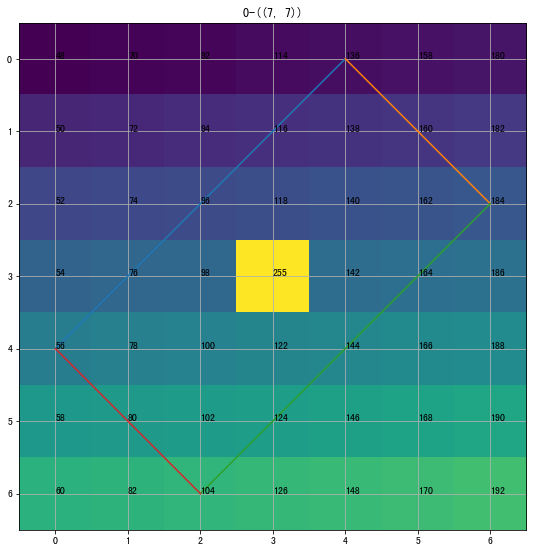

In [5]:
# 获取旋转框的边界
x, y, w, h = cv2.boundingRect(rect)

# 从原图中切出子图
sub_image = img[y:y+h, x:x+w]

# 求出旋转框在子图的位置
new_rect=rect-np.array([[x,y]]).repeat(4,axis=0)

show_images([sub_image],lines=new_rect)

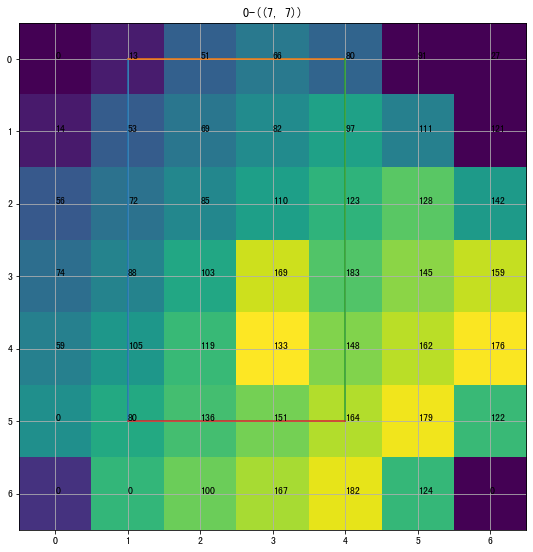

[[ 13  53  72  88 105]
 [ 51  69  85 103 119]
 [ 66  82 110 169 133]]


In [6]:
# 将子图旋转为0度
M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1) # 逆时针角度为正，顺时针角度为负
rotated_sub_image = cv2.warpAffine(sub_image, M, (w, h))

cx, cy = center[0]-x, center[1]-y  # 旋转中心      
angle_deg = 45     # 旋转角度（度） 
# 所有要旋转的点  
now_rect = [rotate_point(cx, cy, rx, ry, -angle_deg) for rx,ry in new_rect ]

show_images([rotated_sub_image],lines=now_rect)

# 取旋转框内的值
X=[rx for rx,ry in now_rect]
Y=[ry for rx,ry in now_rect]
sub_img2=rotated_sub_image[min(X):max(X),min(Y):max(Y)]
print(sub_img2)

In [7]:
# 两种方式的切图比较
diff_img=sub_img2-sub_img1
diff_img.shape,diff_img

((3, 5),
 array([[232, 255,   1,   0,   0],
        [255,   1,   0,   0,   0],
        [  0,   0,   0,   0,   0]], dtype=uint8))